# COURSEWORK SPECIFICATION

## COMM113 - Deep Learning

**Module Lecturers:** Dr Gaojie (Jay) Jin 

**Academic Year:** 2025/26

**Title:** Building MLP on FashionMNIST

**Submission deadline:** 17th November 2025, 11:59am.

This assessment contributes **30%** of the total module mark.

**This is an individual assessment** and you are reminded of the University's regulations on collaboration and plagiarism. You must avoid plagiarism, collusion, and any academic misconduct behaviours. Further details about academic honesty and plagiarism can be found at https://ele.exeter.ac.uk/course/view.php?id=1957.

__________________________

# What to submit

You are required to submit your assignment before **17th November 2025 at 11:59am**.

Please do all your work in this Jupyter notebook. Make a separate cell for every few lines of code, and use separate cells for text, like this one.
Save your file in the format `COMM113_STUDENTNUMBER.ipynb` and zip it.
For example, if your student number is 12345678, save your coursework as `COMM113_12345678.ipynb`.
Once you have done that, zip the file, producing a file called `COMM113_12345678.zip`. This is the file you will have to upload and submit to ELE.

# Learning goals

1. Implement an MLP for image classification.

2. Compare a high-level framework (PyTorch) to a from-scratch NumPy implementation.

3. Track metrics (loss, accuracy) and present results clearly.

# Task 1 (30%): Train a fully connected multilayer perceptron (MLP) on the FashionMNIST dataset for 10 epochs using PyTorch. Your implementation should include:
1. An appropriate loss function for multi-class classification.
2. Suitable activation functions (e.g., ReLU) in the hidden layers.
3. A reasonable choice of layer widths and depth (e.g., two or more hidden layers).
4. Training algorithm with gradient descent.

# Output:
1. Print training loss and training accuracy at the end of each epoch.
2. (Optional) You may also report the test accuracy to demonstrate generalisation performance.

In [1]:
# Set Seed
import random
import numpy as np
import time

SEED = 123
np.random.seed(SEED)
random.seed(SEED)

### Load in the data

In [2]:
# Input the code in the following.  You can adapt the provided code if you like.
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(SEED)
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, random_split

# Define transforms (convert to tensor and normalise) 
# Could add data augmentation to here but with only 10 epochs; doesn't improve performance
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalise to [-1, 1]
])

# Load training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',           # Directory to save/load data
    train=True,              # Load training set
    download=True,           # Download if not already present
    transform=transform      # Apply transforms
)

# Load testing dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',           # Directory to save/load data
    train=False,             # Load Test set
    download=True,           # Download if not already present
    transform=transform      # Apply transforms
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Show some data samples

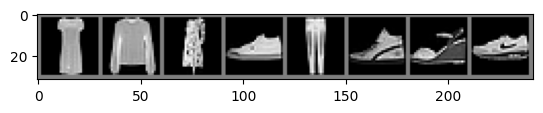

Dress        Pullover     Dress        Sneaker      Trouser      Sneaker      Sandal       Sneaker     


In [3]:
import matplotlib.pyplot as plt
# adapted from https://stackoverflow.com/questions/51329159/how-can-i-generate-and-display-a-grid-of-images-in-pytorch-with-plt-imshow-and-t

# Output some images
def imshow(img):
    img = img / 2 + 0.5   # unnormalise
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Fashion-MNIST class labels
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # show 8 images

# Print labels
print(' '.join(f'{classes[labels[j]]:12s}' for j in range(8)))


### Create the model

In [4]:
# Define the MLP
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        # Input Layer
        self.flatten = nn.Flatten() # flatten layer
                
        # Hidden Layer 1
        self.L1 = nn.Linear(28 * 28, 512) # Linear Layer
        self.bn1 = nn.BatchNorm1d(512) # batch normalisation
        self.drop1 = nn.Dropout(0.2) # drop out
        
        # Hidden Layer 2
        self.L2 = nn.Linear(512, 256) # Linear layer
        self.bn2 = nn.BatchNorm1d(256) # batch norm
        self.drop2 = nn.Dropout(0.2) # drop out

        # Output Layer
        self.OL = nn.Linear(256, 10) # Linear output layer

    def forward(self, out):
        # Input Layer
        out = self.flatten(out) # flatten input matrices into vectors

        # Hidden Layer 1
        out = torch.relu(self.bn1(self.L1(out))) # linear layer normalised and then relu
        out = self.drop1(out) # apply dropout

        # Hidden Layer 2
        out = torch.relu(self.bn2(self.L2(out))) # linear layer normalised and then relu
        out = self.drop2(out) # apply dropout

        # Output Layer
        out = self.OL(out) # get the predictions from the output layer
        return out


# Initialise model, loss function, and optimiser
model = MLP()
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # with Label smoothing 
optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # with L2 regularisation

##### Model architecture - 
- Input layer: 784 neurons (28x28 flattened images)
- Hidden Layer 1: 512 neurons, ReLU activation
- Hidden Layer 2: 256 neurons, ReLU activation
- Output Layer: 10 neurons (one for each class).
 

Between each layer is a ReLU activation function. Batch normalisation, label smoothing, L2 regularisation, and dropout have been added for regularisation.
Trained with a learning rate of 0.001 and a batch size of 64 for 10 epochs using the Adam optimiser with a Cross-Entropy loss function.


##### Why these choices?
- **Batch Normalisation** helps stabilise training by normalising layer activations so gradients are more consistent.
- **Dropout** helps prevent overfitting by randomly switching off neurons during training.
- **Label Smoothing** prevents the network becoming overconfident and usually improves generalisation, by softening the target labels.
- **Adam Optimiser** adapts the learning rate throughout training, which allows the model to converge faster and more smoothly than SGD.
- **L2 Regularisation** adds a small penalty to large weights to reduce overfitting.

These methods helped improve accuracy and produce a smoother training curve in both implementations.


### Train the model for one epoch

In [5]:
# Training Function for one epoch
def train_one_epoch(model, loader, criterion, optimiser):    
    model.train() # set the model into training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in loader: # mini-batching - loop through the batches
        # Zero gradients from previous iteration
        optimiser.zero_grad()

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward() # compute the gradients

        # update the weights
        optimiser.step()

        # Track loss
        running_loss += loss.item()  # compute total loss for that batch so it can be averaged across all batches

        # Track accuracy
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

    # Epoch stats
    epoch_loss = running_loss / len(loader) # average the loss across all batches
    epoch_acc = 100 * correct / total # calculate the accuracy of the model over the epoch

    return epoch_loss, epoch_acc

### Create function to evaluate the model

In [6]:
# Evaluate function
def evaluate(model, test_loader, criterion):
    model.eval() # set model to eval - turn off dropout
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader: # mini-batching

            # compute the outputs
            outputs = model(X_batch) 

            # compute the loss
            loss = criterion(outputs, y_batch)

            running_loss += loss.item()  # compute total loss for that batch so it can be averaged across the whole dataset
            
            # Accuracy Calculations
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    test_loss = running_loss / len(test_loader) # average the loss across all batches
    test_accuracy = 100 * correct / total # calculate the accuracy of the model over the epoch
    
    return test_loss, test_accuracy

### Train the model

In [7]:
# Training function across all epochs
EPOCHS = 10
train_losses, train_accuracy = [],[]
test_losses, test_accuracy = [],[]

print(f'Model Training on CPU')
print('-'*100)

start_time = time.time()
for epoch in range(EPOCHS):
    # train for one epoch
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimiser)

    # evaluate 
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    # store all metrics in lists for the plot
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

    # output the epoch number, training loss and accuracy, testing loss and accuracy
    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")
    
end_time = time.time()

training_time_py = end_time - start_time  # calculate how long the model has been training for

print('-' * 100)
print(f'Training Completed in {training_time_py:.2f} Seconds')

print('-' * 100)
print(f"Final Training Accuracy: {round(train_accuracy[-1],2)}% | Final Testing Accuracy {round(test_accuracy[-1],2)}%")

Model Training on CPU
----------------------------------------------------------------------------------------------------
Epoch [1/10] | Train Loss: 0.8823 | Train Acc: 83.43% | Test Loss: 0.8194 | Test Acc: 85.47%
Epoch [2/10] | Train Loss: 0.8086 | Train Acc: 86.77% | Test Loss: 0.8027 | Test Acc: 86.27%
Epoch [3/10] | Train Loss: 0.7874 | Train Acc: 87.66% | Test Loss: 0.7878 | Test Acc: 87.02%
Epoch [4/10] | Train Loss: 0.7740 | Train Acc: 88.28% | Test Loss: 0.7702 | Test Acc: 88.05%
Epoch [5/10] | Train Loss: 0.7635 | Train Acc: 88.86% | Test Loss: 0.7835 | Test Acc: 87.35%
Epoch [6/10] | Train Loss: 0.7561 | Train Acc: 89.17% | Test Loss: 0.7783 | Test Acc: 87.35%
Epoch [7/10] | Train Loss: 0.7507 | Train Acc: 89.53% | Test Loss: 0.7718 | Test Acc: 87.85%
Epoch [8/10] | Train Loss: 0.7435 | Train Acc: 89.83% | Test Loss: 0.7653 | Test Acc: 88.00%
Epoch [9/10] | Train Loss: 0.7385 | Train Acc: 89.93% | Test Loss: 0.7595 | Test Acc: 88.52%
Epoch [10/10] | Train Loss: 0.7352 | Tra

#### Show some predictions

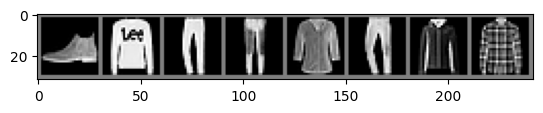

Actual:  Ankle boot   Pullover     Trouser      Trouser      Shirt        Trouser      Coat         Shirt       


In [8]:
# Get some random test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # show 8 images

# Print labels
print('Actual: ', ' '.join(f'{classes[labels[j]]:12s}' for j in range(8)))

In [9]:
# Visualise Outputs for above sample of images
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:12s}'
                              for j in range(8)))

Predicted:  Ankle boot   Pullover     Trouser      Trouser      Shirt        Trouser      Coat         Shirt       


### Training vs Test Loss + Training vs Test Accuracy

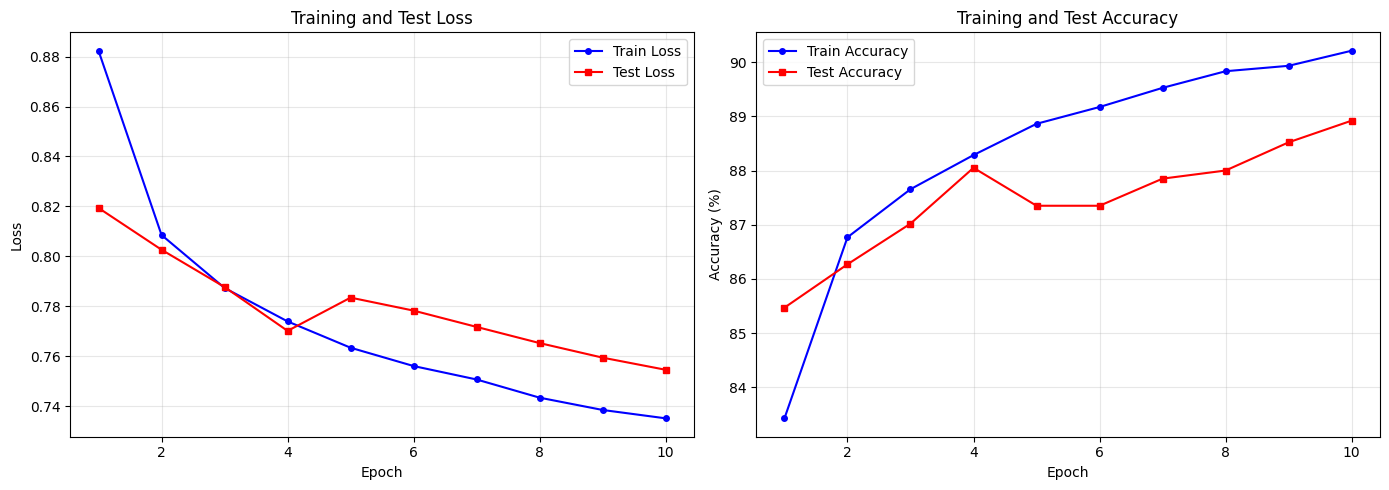

In [10]:
# Graph for training vs test losses + training vs test accuracy
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
ax1.plot(range(1, EPOCHS + 1), train_losses, 'b-o', label='Train Loss', markersize=4)
ax1.plot(range(1, EPOCHS + 1), test_losses, 'r-s', label='Test Loss', markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(range(1, EPOCHS + 1), train_accuracy, 'b-o', label='Train Accuracy', markersize=4)
ax2.plot(range(1, EPOCHS + 1), test_accuracy, 'r-s', label='Test Accuracy', markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Task 2 (70%): Train a fully connected multilayer perceptron (MLP) on the FashionMNIST dataset for 10 epochs using Numpy Only. Your implementation should include:
1. An appropriate loss function for multi-class classification.
2. Suitable activation functions (e.g., ReLU) in the hidden layers.
3. A reasonable choice of layer widths and depth (e.g., two or more hidden layers).
4. Training algorithm with gradient descent.

# Output:
1. Print training loss and training accuracy at the end of each epoch.
2. (Optional) You may also report the test accuracy to demonstrate generalisation performance.

# Note: You can only use Numpy to build the MLP and develop the training algorithm.

### Load in the data

In [11]:
# Input the code in the following. You can adapt the provided code if you like.
import gzip
import numpy as np
def load_mnist_images(filename):
    """Load images from Fashion-MNIST format"""
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    return data.reshape(-1, 28, 28)

def load_mnist_labels(filename):
    """Load labels from Fashion-MNIST format"""
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

# Load training dataset
x_train = load_mnist_images('./data/FashionMNIST/raw/train-images-idx3-ubyte.gz')
x_train = (x_train.reshape(-1, 784) / 255.0 - 0.5) / 0.5   # Flatten the images and then normalise

y_train = load_mnist_labels('./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz') # load in the y labels - train

# Load test dataset
x_test = load_mnist_images('./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz')
x_test = (x_test.reshape(-1, 784) / 255.0 - 0.5) / 0.5 # Flatten the images and then normalise

y_test = load_mnist_labels('./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz') # load in the y labels - test

print("Train shape:", x_train.shape, y_train.shape)
print("Test shape:", x_test.shape, y_test.shape)

Train shape: (60000, 784) (60000,)
Test shape: (10000, 784) (10000,)


### Create the model class - create optimiser, loss function, forward pass, and backpropagation methods

In [12]:
# building a class for the MLP so all functions can be called from one instance
class MLP:
    def __init__(self, inp_size, hid1_size, hid2_size, out_size):
        # Randomly initialise weights
        self.w_in_h1 = np.random.randn(inp_size, hid1_size) * 0.1
        self.w_h1_h2 = np.random.randn(hid1_size, hid2_size) * 0.1
        self.w_h2_out = np.random.randn(hid2_size, out_size) * 0.1

        # Initialise biases to 0
        self.b_in_h1 = np.zeros((1, hid1_size))
        self.b_h1_h2 = np.zeros((1, hid2_size))
        self.b_h2_out = np.zeros((1, out_size))

        # L2 regularisation
        self.lambda_ = 1e-4

        # Momentum buffers
        self.momentum = 0.9
        self.prev_dw1 = np.zeros_like(self.w_in_h1)
        self.prev_dw2 = np.zeros_like(self.w_h1_h2)
        self.prev_dw3 = np.zeros_like(self.w_h2_out)

        # Dropout prob
        self.dropout = 0.2

        # Label smoothing
        self.smoothing = 0.1
        self.out_size = out_size

        # Makes sure in eval there is no dropout unless it was run in train
        self.drop_mask1 = None
        self.drop_mask2 = None

        #  Adam Optimiser params 
        self.beta1_m = 0.9   # Adam momentum term
        self.beta2_v = 0.999 # Adam velocity term
        self.eps = 1e-8 # stop division by 0
        self.t = 0  # time step

        # Adam moment + velocity estimates for each weight and bias
        # Weight 1
        self.m_w1 = np.zeros_like(self.w_in_h1) # set the momentum to have the same shape as H1 weights
        self.v_w1 = np.zeros_like(self.w_in_h1) # set the velocity to have the same shape as H1 weights

        # Weight 2
        self.m_w2 = np.zeros_like(self.w_h1_h2) # set the momentum to have the same shape as H2 weights
        self.v_w2 = np.zeros_like(self.w_h1_h2) # set the velocity to have the same shape as H2 weights

        # Weight 3
        self.m_w3 = np.zeros_like(self.w_h2_out) # set the momentum to have the same shape as H3 weights
        self.v_w3 = np.zeros_like(self.w_h2_out) # set the velocity to have the same shape as H3 weights

        # Bias 1
        self.m_b1 = np.zeros_like(self.b_in_h1) # set the momentum to have the same shape as H1 bias
        self.v_b1 = np.zeros_like(self.b_in_h1) # set the velocity to have the same shape as H1 bias

        # Bias 2
        self.m_b2 = np.zeros_like(self.b_h1_h2) # set the momentum to have the same shape as H2 bias
        self.v_b2 = np.zeros_like(self.b_h1_h2) # set the velocity to have the same shape as H2 bias
        
        # Bias 3
        self.m_b3 = np.zeros_like(self.b_h2_out) # set the momentum to have the same shape as H3 bias
        self.v_b3 = np.zeros_like(self.b_h2_out) # set the velocity to have the same shape as H3 bias

        # batch norm params 
        self.gamma1 = np.ones((1, hid1_size)) # set to all ones - vector with length hid1
        self.beta1_bn = np.zeros((1, hid1_size)) # set to all zeroes - vector with length hid1
        self.gamma2 = np.ones((1, hid2_size)) # set to all ones - vector with length hid2
        self.beta2_bn = np.zeros((1, hid2_size)) # set to all zeros - vector with length hid2
        self.bn_momentum = 0.9  # running avg factor

        # Running stats for batch norm eval
        self.run_mean1 = np.zeros((1, hid1_size)) # set to all zeros - vector with length hid1
        self.run_var1 = np.ones((1, hid1_size)) # set to all ones - vector with length hid1
        self.run_mean2 = np.zeros((1, hid2_size)) # set to all zeros - vector with length hid2
        self.run_var2 = np.ones((1, hid2_size)) # set to all ones - vector with length hid2

    # Activation functions as static methods
    @staticmethod
    def ReLU(x):
        return np.maximum(0.0, x) # force negatives to 0 and positives to stay the same

    @staticmethod
    def ReLU_deriv(x):
        return (x > 0).astype(float) # negatives become 0, positives become 1

    # Softmax
    @staticmethod
    def SoftMax(x):  # define softmax function - converts logits into probs that sum to 1 - softmax(x_i) = exp(x_i) / Σ_j exp(x_j)
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    # Label smoothing
    def smooth_labels(self, y, num_classes):

        y_onehot = np.zeros((len(y), num_classes))  # creates a matrix with the shape (number of samples, number of classes)
        y_onehot[np.arange(len(y)), y] = 1 # converts class indicies into one-hot encodings

        conf = 1.0 - self.smoothing # defines a level of confidence in the correct class - (1 - α)

        return conf * y_onehot + self.smoothing / num_classes # return the label smoothed one-hot vector - # y_smooth = (1 - α) * y_onehot + α / K

    # batch norm forward
    # adapted from https://medium.com/@ghoshanurag66/batch-normalization-math-and-implementation-fe06293f7443
    # and https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

    def batch_norm(self, x, gamma, beta, run_mean, run_var, training=True):
        if training: # if model in training mode

            mean = x.mean(axis=0) # calculate the mean of the batch
            var = x.var(axis=0) # calculate the variance of the batch

            x_hat = (x - mean) / np.sqrt(var + self.eps) # normalise the batch
            out = gamma * x_hat + beta # output becomes the location transformed batch

            # update running stats
            run_mean[:] = self.bn_momentum * run_mean + (1 - self.bn_momentum) * mean
            run_var[:] = self.bn_momentum * run_var + (1 - self.bn_momentum) * var

            cache = (x, x_hat, mean, var, gamma, beta) # save the params in a cache tuple
            return out, cache # return the output and cache
        
        else: # if the model is being evaluated
            x_hat = (x - run_mean) / np.sqrt(run_var + self.eps) # use running mean and varaince to normalise
            out = gamma * x_hat + beta # output becomes the location transformed batch
            return out, None # return the output x

    # batch norm backward - 
    # adapted from https://medium.com/@ghoshanurag66/batch-normalization-math-and-implementation-fe06293f7443
    # and https://www.kaggle.com/code/moazeldsokyx/deep-neural-network-dnn-from-scratch-with-numpy
    # and https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html

    def batch_norm_backward(self, dout, cache): # dout is the gradient w.r.t activation after batch norm e.g. dz3 - gradient w.r.t output
        x, x_hat, mean, var, gamma, _ = cache # unpack the variables from cache populated during forward pass
        rows = x.shape[0]

        # compute gradients w.r.t learnable parameters, gamma and beta
        dgamma = np.sum(dout * x_hat, axis=0, keepdims=True) # gradient w.r.t gamma
        dbeta = np.sum(dout, axis=0, keepdims=True) # gradient w.r.t beta

        dx_hat = dout * gamma # gradient w.r.t normalised x
        
        dvar = np.sum(dx_hat * (x - mean) * -0.5 * (var + self.eps) ** (-1.5), axis=0) # gradient w.r.t the variance 
        dmean = np.sum(dx_hat * -1 / np.sqrt(var + self.eps), axis=0) + dvar * np.mean(-2 * (x - mean), axis=0) # gradient w.r.t the mean

        # derivative of output w.r.t input
        dx = dx_hat / np.sqrt(var + self.eps) + dvar * 2 * (x - mean) / rows + dmean / rows # gradient w.r.t x

        return dx, dgamma, dbeta # return gradients of x, gamma and beta, so they can be used to update parameters

    #  Forward pass 
    def forward(self, X, training=True):
        
        # Input → Hidden 1
        self.z1 = np.dot(X, self.w_in_h1) + self.b_in_h1 # z1 = xW + b
        self.z1, self.bn_cache1 = self.batch_norm(
            self.z1, self.gamma1, self.beta1_bn, self.run_mean1, self.run_var1, training=training
        ) # apply batch normalisation
        self.a1 = self.ReLU(self.z1) # a1 = σ(z1)

        # Dropout Based off - http://d2l.ai/chapter_multilayer-perceptrons/dropout.html
        if training: # if the model is training
            self.drop_mask1 = (np.random.rand(*self.a1.shape) > self.dropout).astype(np.float32) # create a mask with the same shape as the activations
            self.a1 = self.a1 * self.drop_mask1 / (1 - self.dropout) # apply the mask - sets some activattions to 0
        else: # if not training
            self.drop_mask1 = None # no mask and a1 doesn't change

        # Hidden 1 → Hidden 2
        self.z2 = np.dot(self.a1, self.w_h1_h2) + self.b_h1_h2 # z2 = a1W + b
        self.z2, self.bn_cache2 = self.batch_norm(
            self.z2, self.gamma2, self.beta2_bn, self.run_mean2, self.run_var2, training=training
        ) # apply batch normalisation
        self.a2 = self.ReLU(self.z2) # a2 = σ(z2)

        # Dropout Based off - http://d2l.ai/chapter_multilayer-perceptrons/dropout.html
        if training:  # if the model is training
            self.drop_mask2 = (np.random.rand(*self.a2.shape) > self.dropout).astype(np.float32) # create a mask with the same shape as the activations
            self.a2 = self.a2 * self.drop_mask2 / (1 - self.dropout) # apply the mask - sets some activattions to 0
        else: # if not training
            self.drop_mask2 = None # no mask and a2 doesn't change

        # Hidden 2 → Output
        self.z3 = np.dot(self.a2, self.w_h2_out) + self.b_h2_out # z3 = a2W + b
        self.out_softmax = self.SoftMax(self.z3) # a3 = σ(z3) - appluy softmax to get probs from logits

        return self.out_softmax # return the probs of each class - returning a3 vector

    # Cross-entropy + L2 regularisation 
    def cross_entropy(self, y_pred, y_true):
        rows = y_pred.shape[0] # get the length of the batch

        loss = -np.sum(y_true * np.log(y_pred + self.eps)) / rows # calculate the loss

        l2 = self.lambda_ * ( # calculate the l2 penalty term - sum of squares of all weights = Σ w^2
            np.sum(self.w_in_h1**2) +
            np.sum(self.w_h1_h2**2) +
            np.sum(self.w_h2_out**2)
        )

        return loss + l2 # return the loss + L2 reg term

    #  Backward pass 
    def backward(self, X, y_smooth, out, lr):
        rows = X.shape[0] # get the length of the batch

        # Output layer
        dZ3 = (out - y_smooth) / rows # calculate the gradient w.r.t loss function averaged over the batch
        dW3 = np.dot(self.a2.T, dZ3) + 2 * self.lambda_ * self.w_h2_out # calculate the gradient w.r.t output weights and add L2 reg term
        db3 = np.sum(dZ3, axis=0, keepdims=True) # calculate the gradient w.r.t output bias

        # Hidden 2
        dA2 = np.dot(dZ3, self.w_h2_out.T) # calculate the gradient w.r.t post activation vector

        if self.drop_mask2 is not None: # if dropout was applied through training
            dA2 *= self.drop_mask2 # apply the same dropout mask to the gradiients - makes sure only neurons activated receive the gradient updates

        dZ2 = dA2 * self.ReLU_deriv(self.z2) # calculate the gradient w.r.t relu function
        dZ2, dgamma2, dbeta2 = self.batch_norm_backward(dZ2, self.bn_cache2) # calculate the gradients w.r.t batch normalisation function
        dW2 = np.dot(self.a1.T, dZ2) + 2 * self.lambda_ * self.w_h1_h2 # calculate the gradient w.r.t weight matrix and add L2 reg term
        db2 = np.sum(dZ2, axis=0, keepdims=True) # calculate the gradients w.r.t bias vector

        # Hidden 1
        dA1 = np.dot(dZ2, self.w_h1_h2.T)  # calculate the gradient w.r.t post activation vector

        if self.drop_mask1 is not None:
            dA1 *= self.drop_mask1 # apply the same dropout mask to the gradiients - makes sure only neurons activated receive the gradient updates

        dZ1 = dA1 * self.ReLU_deriv(self.z1) # calculate the gradient w.r.t relu function
        dZ1, dgamma1, dbeta1 = self.batch_norm_backward(dZ1, self.bn_cache1) # calculate the gradients w.r.t batch normalisation function

        dW1 = np.dot(X.T, dZ1) + 2 * self.lambda_ * self.w_in_h1 # calculate the gradient w.r.t weight matrix and add L2 reg term
        db1 = np.sum(dZ1, axis=0, keepdims=True) # calculate the gradients w.r.t bias vector

        # Update batch norm params using SGD
        self.gamma1 -= lr * dgamma1
        self.beta1_bn -= lr * dbeta1
        self.gamma2 -= lr * dgamma2
        self.beta2_bn -= lr * dbeta2

        # ADAM Optimiser - adapted from https://www.youtube.com/watch?v=M4HQHmBrAmI
        # and https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html
        # implmented to match the Pytorch Adam so the models are comparable
        self.t += 1  # increment time step

        # define the adam optimiser to update the weights
        def adam_update(param, grad_param, moment, velocity):
            moment = self.beta1_m * moment + (1 - self.beta1_m) * grad_param # moment calculated
            velocity = self.beta2_v * velocity + (1 - self.beta2_v) * (grad_param ** 2) # velocity calculated

            # bias correction
            mom_corr = moment / (1 - self.beta1_m ** self.t) 
            vel_corr = velocity / (1 - self.beta2_v ** self.t) 

            # update the parameter
            param -= lr * mom_corr / (np.sqrt(vel_corr) + self.eps)

            return param, moment, velocity # return the updated param, moment, velocity

        # Update the parameters
        # Input → Hidden 1
        self.w_in_h1, self.m_w1, self.v_w1 = adam_update(self.w_in_h1, dW1, self.m_w1, self.v_w1) # weight update
        self.b_in_h1, self.m_b1, self.v_b1 = adam_update(self.b_in_h1, db1, self.m_b1, self.v_b1) # bias update

        # Hidden 1 → Hidden 2
        self.w_h1_h2, self.m_w2, self.v_w2 = adam_update(self.w_h1_h2, dW2, self.m_w2, self.v_w2) # weight update
        self.b_h1_h2, self.m_b2, self.v_b2 = adam_update(self.b_h1_h2, db2, self.m_b2, self.v_b2) # bias update

        # Hidden 2 → Output
        self.w_h2_out, self.m_w3, self.v_w3 = adam_update(self.w_h2_out, dW3, self.m_w3, self.v_w3) # weight update
        self.b_h2_out, self.m_b3, self.v_b3 = adam_update(self.b_h2_out, db3, self.m_b3, self.v_b3) # bias update

    # Train one epoch 
    def train_one_epoch(self, X, y, lr, batch_size=64, shuffle=True):
        rows = X.shape[0]

        # implemented because dataloader does this automatically
        if shuffle: # shuffle the batches each epoch
            idx = np.arange(rows) # create an array of the length of the input
            np.random.shuffle(idx) # randomly shuffle these inputs
            X, y = X[idx], y[idx] # assign new x + y order

        total_loss, correct = 0.0, 0 # initalise loss and correct
        for i in range(0, rows, batch_size): # loop through the dataset using batch size

            X_batch = X[i:i+batch_size] # create the X batch
            y_batch = y[i:i+batch_size] # create the Y batch

            out = self.forward(X_batch, training=True) # calculate the ouput of the model

            y_smooth = self.smooth_labels(y_batch, self.out_size) # apply label smoothing to the targets

            self.backward(X_batch, y_smooth, out, lr) # compute gradients and upadate all params

            batch_loss = self.cross_entropy(out, y_smooth) # calcaulte the batch loss

            total_loss += batch_loss  # add that batch loss to the total loss for the epoch
            preds = np.argmax(out, axis=1) # calculate what the prediction is for each input image
            correct += np.sum(preds == y_batch) # add the correct predictions to a total

        num_batches = (rows + batch_size - 1) // batch_size  # get the number of batches account for last incomplete batch
        return total_loss / num_batches, correct / rows # return average loss and no. correct of that epoch 

    # Evaluate
    def evaluate(self, X, y, batch_size=64):

        rows = X.shape[0]

        total_loss, correct = 0.0, 0 # initalise loss and correct

        for i in range(0, rows, batch_size): # loop through the dataset using batch size

            X_batch = X[i:i+batch_size] # create the image batch
            y_batch = y[i:i+batch_size] # create the labels batch

            out = self.forward(X_batch, training=False) # calculate the output of the model

            # Apply label smoothing
            y_smooth = self.smooth_labels(y_batch, self.out_size)
            batch_loss = self.cross_entropy(out, y_smooth) # calculate the loss of that batch

            total_loss += batch_loss  # add that batch loss to the total loss for the epoch
            preds = np.argmax(out, axis=1) # calculate what the prediction is for each input image
            correct += np.sum(preds == y_batch) # add the correct predictions to a total

        num_batches = (rows + batch_size - 1) // batch_size  # get the number of batches account for last incomplete batch
        return total_loss / num_batches, correct / rows # return average loss and no. correct of that epoch 


##### Model architecture - This Numpy-Only model uses the same architecture as task one to allow for a fair comparison so differences in performance can be attributed to the implementation rather than architecture.

 





In [13]:
# Train Model
mlp = MLP(inp_size=784, hid1_size=512, hid2_size=256, out_size=10) # create the instance of the model with the depth of the model

# Training loop
EPOCHS = 10 # set 10 epochs
train_losses, train_accuracy = [], []
test_losses, test_accuracy = [], []

print(f'Model Training on CPU')
print('-' * 100)

start_time = time.time()
for epoch in range(EPOCHS): # repeat the training for the set number of epochs
    # train for one epoch
    train_loss, train_acc = mlp.train_one_epoch(x_train, y_train, lr=0.001, batch_size=64)
    
    # evaluate on test set
    test_loss, test_acc = mlp.evaluate(x_test, y_test, batch_size=64)
    
    # store metrics
    train_losses.append(train_loss)
    train_accuracy.append(train_acc * 100)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc * 100)
    
    # print epoch summary
    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | "
        f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")
    
end_time = time.time()

training_time_num =  end_time - start_time

print('-' * 100)
print(f'Training Completed in {training_time_num:.2f} Seconds')

print('-' * 100)
print(f"Final Training Accuracy: {train_accuracy[-1]:.2f}% | Final Testing Accuracy: {test_accuracy[-1]:.2f}%")

Model Training on CPU
----------------------------------------------------------------------------------------------------
Epoch [1/10] | Train Loss: 1.3417 | Train Acc: 82.12% | Test Loss: 1.1291 | Test Acc: 84.98%
Epoch [2/10] | Train Loss: 1.0639 | Train Acc: 85.91% | Test Loss: 0.9817 | Test Acc: 86.31%
Epoch [3/10] | Train Loss: 0.9496 | Train Acc: 87.07% | Test Loss: 0.9232 | Test Acc: 86.32%
Epoch [4/10] | Train Loss: 0.8945 | Train Acc: 87.30% | Test Loss: 0.8751 | Test Acc: 86.80%
Epoch [5/10] | Train Loss: 0.8678 | Train Acc: 87.54% | Test Loss: 0.8671 | Test Acc: 86.62%
Epoch [6/10] | Train Loss: 0.8514 | Train Acc: 87.70% | Test Loss: 0.8476 | Test Acc: 87.09%
Epoch [7/10] | Train Loss: 0.8451 | Train Acc: 87.78% | Test Loss: 0.8520 | Test Acc: 87.08%
Epoch [8/10] | Train Loss: 0.8400 | Train Acc: 87.98% | Test Loss: 0.8547 | Test Acc: 86.99%
Epoch [9/10] | Train Loss: 0.8380 | Train Acc: 88.10% | Test Loss: 0.8311 | Test Acc: 87.69%
Epoch [10/10] | Train Loss: 0.8340 | Tra

### Training vs Test Loss + Training vs Test Accuracy

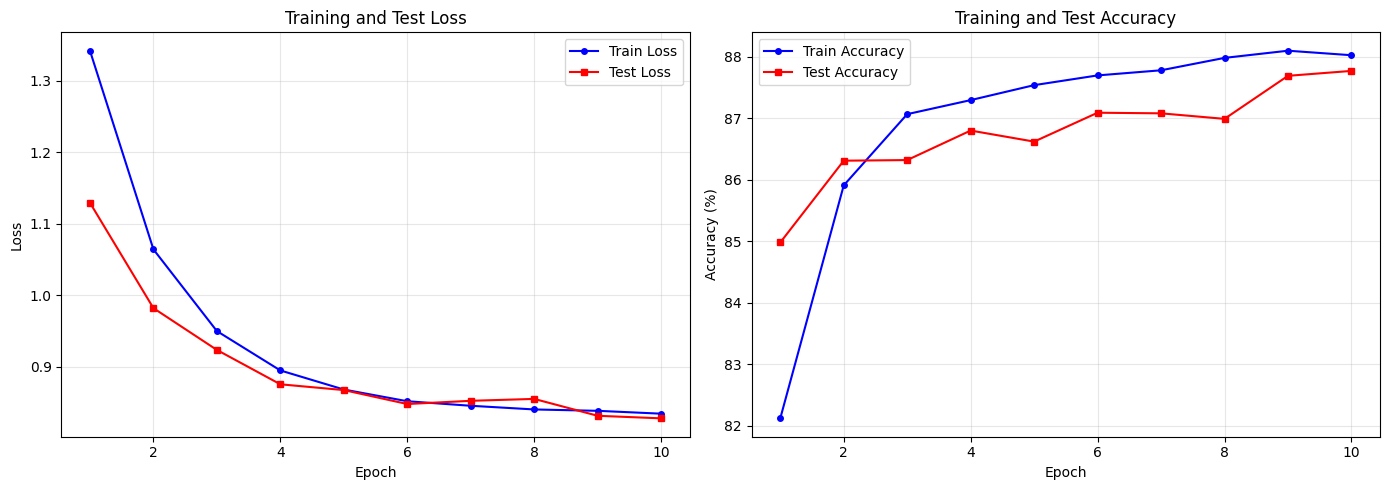

In [14]:
# Graph for training vs test losses + training vs test accuracy
# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
ax1.plot(range(1, EPOCHS + 1), train_losses, 'b-o', label='Train Loss', markersize=4)
ax1.plot(range(1, EPOCHS + 1), test_losses, 'r-s', label='Test Loss', markersize=4)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracies
ax2.plot(range(1, EPOCHS + 1), train_accuracy, 'b-o', label='Train Accuracy', markersize=4)
ax2.plot(range(1, EPOCHS + 1), test_accuracy, 'r-s', label='Test Accuracy', markersize=4)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparison Between Pytorch and Numpy-only Implementation

Both implementations achieved similar performance on the FashionMNIST dataset, with training accuracies around 88-90% and test accuracies around 87-89%. The loss curves for both models showed a steady decrease over the epochs, indicating effective learning.

The numpy only implementation took longer to train compared to the PyTorch version, almost twice as long. This is expected, as PyTorch is optimised for performance using C++ as a backend and while the numpy implementation is built only using Python.

Interestingly, the numpy implementation showed a slightly better training dynamic with smoother convergence in loss and accuracy curves. This could be due to the more explicit control over the training process in the numpy implementation, allowing for finer adjustments to hyperparameters and regularisation techniques. Also, the numpy implementation sees slightly less overfitting, with a smaller gap between training and test accuracy.

